<img src='otus.png'>

## План лекции
- bias-variance tradeoff
- композиции алгоритмов (in general)
- bootstrap
- bagging
- RSM (random subsampling method)
- RandomForest
  * алгоритм
  * oob
  * важности признаков
- Boosting
  * adaboost
- Blending, stacking

## Bias variance tradeoff

https://www.bogotobogo.com/python/scikit-learn/scikit_machine_learning_Bias-variance-Tradeoff.php

https://en.wikipedia.org/wiki/Bias–variance_tradeoff

https://ru.wikipedia.org/wiki/Дилемма_смещения–дисперсии

<img src='bias_variance.png' width=40%>

* $\text{Bias}$ (Смещение) - точность модели. Высокое смещение чаще всего означает, что модель недообучена (underfitting). 

$Bias[f'(x)] = E[f'(x)] - f(x)$<br>

* $\text{Variance}$ (Разброс) - чувствительность модели к данным. Высокие разброс чаще всего означает, что модель переобучена (overfitting)

$Var[f'(x)] = E[f'(x)^2] - (E[f'(x)])^2$<br>

* $\text{Noise}$ (Шум) 



Функция, описывающая данные:
$y=f(x)+ε$<br>
$E(ε)=0$<br>
$Var(ε)=\sigma^2$<br>
Хотим найти $f'(x)$

Оцениваем ее качество по ожидаемой ошибке

$E[(f(x) - f'(x))^2] = (Bias[f'(x)])^2 + Var[f'(x)] + \sigma^2$

Вывод формулы

$$E[(y - f')^2] = E[y^2 + f'^2 - 2 y f'] = E[y^2] + E[f'^2] - E[2yf'] = Var[y] + E[y]^2 + Var[{f'}] + E[f']^2 - 2fE[f'] = Var[y] + Var[f'] + (f - E[f'])^2 $$

# Ансамбли моделей


### Мудрость толпы

Если спросить много людей о некоторой характеристике и усреднить - получится результат лучше, чем полученный от одного эксперта.  

В онлайне размещена картинка с коровой. Люди заходят на сайт и дают оценку ее веса. Средний результат из 17000 предсказаний отклоняется от действительного значения на 5%.

https://en.wikipedia.org/wiki/Wisdom_of_the_crowd

### Теорема Кондорсе «о жюри присяжных»

https://ru.wikipedia.org/wiki/Парадокс_Кондорсе
<img src='classifier_voting.png' width=80%>

## Voting Classifiers

In [17]:
from __future__ import print_function
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings("ignore")

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

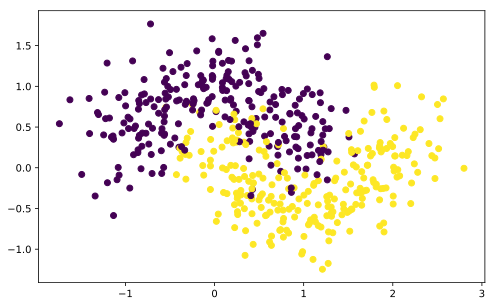

In [19]:
plt.scatter(X[:, 0], X[:, 1], c=y);

### Hard voting
Построим несколько простых моделей на одних и тех же данных.  
Предсказание будем делать всеми моделями, в результате предсказания выберем тот класс, за который проголосовало большинство моделей - **hard voting**

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         n_jobs=1, voting='hard', weights=None)

In [21]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


### Soft voting
Если все классификаторы могут вернуть вероятность (реализован метод predict proba), то можем посчитать среднее - **soft voting**

In [22]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         n_jobs=1, voting='soft', weights=None)

In [23]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


In [24]:
voting_clf.predict_proba(X_test)

array([[ 0.55611089,  0.44388911],
       [ 0.80333358,  0.19666642],
       [ 0.65955121,  0.34044879],
       [ 0.01814628,  0.98185372],
       [ 0.05134482,  0.94865518],
       [ 0.15924051,  0.84075949],
       [ 0.9867671 ,  0.0132329 ],
       [ 0.98152668,  0.01847332],
       [ 0.67056686,  0.32943314],
       [ 0.97606993,  0.02393007],
       [ 0.01518898,  0.98481102],
       [ 0.98586598,  0.01413402],
       [ 0.06419684,  0.93580316],
       [ 0.19269823,  0.80730177],
       [ 0.0758089 ,  0.9241911 ],
       [ 0.92570277,  0.07429723],
       [ 0.97786368,  0.02213632],
       [ 0.05877976,  0.94122024],
       [ 0.20202757,  0.79797243],
       [ 0.93547522,  0.06452478],
       [ 0.95414873,  0.04585127],
       [ 0.15762376,  0.84237624],
       [ 0.43418963,  0.56581037],
       [ 0.80736295,  0.19263705],
       [ 0.93426248,  0.06573752],
       [ 0.81541138,  0.18458862],
       [ 0.18637412,  0.81362588],
       [ 0.9866982 ,  0.0133018 ],
       [ 0.0206927 ,

На ирисах:

In [25]:
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.900 (+/- 0.05) [Logistic Regression]
Accuracy: 0.933 (+/- 0.05) [Random Forest]
Accuracy: 0.913 (+/- 0.04) [naive Bayes]
Accuracy: 0.947 (+/- 0.05) [Ensemble]


In [26]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from itertools import product
from sklearn.ensemble import VotingClassifier

# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0,2]]
y = iris.target

# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)], voting='soft', weights=[1, 1, 1])

clf1 = clf1.fit(X,y)
clf2 = clf2.fit(X,y)
clf3 = clf3.fit(X,y)
eclf = eclf.fit(X,y)


for clf, label in zip([clf1, clf2, clf3, eclf], ['Decision Tree', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.927 (+/- 0.07) [Decision Tree]
Accuracy: 0.940 (+/- 0.04) [Random Forest]
Accuracy: 0.947 (+/- 0.03) [naive Bayes]
Accuracy: 0.947 (+/- 0.05) [Ensemble]


### Подбор параметров

In [27]:
from sklearn.model_selection import GridSearchCV
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')

params = {'lr__C': [1.0, 100.0],
          'rf__n_estimators': [20, 200]}

grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
grid = grid.fit(iris.data, iris.target)

In [28]:
grid.best_estimator_.estimators

[('lr',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False)),
 ('rf',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, n_jobs=1, oob_score=False, random_state=1,
              verbose=0, warm_start=False)),
 ('gnb', GaussianNB(priors=None))]

## Bootstrap

$N$ раз выбираем элементы с повторением из выборки. Сгенерируем $M$ подвыборок $X_1, X_2,...,X_m$. По каждой из данных выборок мы можем оценивать различные статистики.<br>
Например, предположим, что мы хотим оценить средний вес среди всех людей в мире. У нас нет возможности взвесить всех людей, но мы можем взять небольшую выборку размера $N$ и взвесить всех этих людей. По такой выборке мы можем только оценить среднее. Однако чтобы делать выводы и генеральной совокупности, нам необходимо больше информации и разбросе среднего, как если бы мы оценили средний вес по нескольким таким выборкам.

<img src='pics/bootstrap-sample.png'>

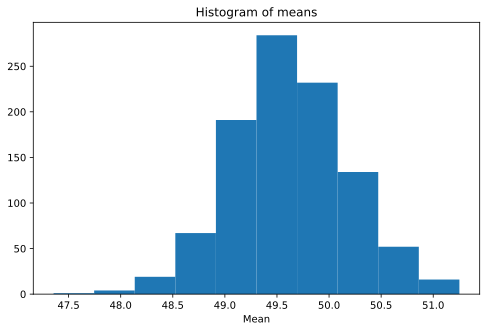

In [29]:

from sklearn.utils import resample

N = 1000 # Sample size
M = 1000 # Number of bootstrap samples
X = 50.0 + 10 * np.random.randn(N) # Initial sample

# Resampling M times with replacement from X and estimating mean every time
means = [np.mean(resample(X,n_samples=300)) for i in range(M)] 
    
plt.hist(means)
plt.title('Histogram of means')
plt.xlabel('Mean');

# Bagging - bootstrap aggregation

Из выборки генерируем сэмпл. Сэмплирование делаем с возвращением.

In [30]:
def subsample(data, ratio=1.0):
    return np.random.choice(data, size=int(data.shape[0] * ratio), replace=True)

In [31]:
dataset = np.random.randint(0, 1000, size=1000)

In [32]:
np.unique(np.bincount(dataset))

array([0, 1, 2, 3, 4, 5])

In [33]:
sample = subsample(dataset, ratio=0.4)

In [34]:
print(sample)

[985 436  57 580 345 723 877 809 979 943 359 773 436 548 496 851 562 954
 411 264 220 572 984 624 438 349 495 984 103 567 293 220 934 768 679 494
 491 332 825 740 917 300 326 862 475 567 846 250 929  79 884 954 995 607
 711 760 662 396 716 772 812 644 459  80 666 943 374  92 112 310  13 349
 483 410 154 403 286 756 602  55 839  62 131 876 706 680 105 220 751 734
 953 733 491 625 443 976 289 904 407 742 106 115 955 606 142 670 863 516
 243 336 515 756 320 237 877 263 966 459 303 536 613 195 706 185 839 190
 168 628 877 700  31 876 170 844  38 369 651 192 189 699 644 305 562  18
 959 314 894 204 893  67 689 772 206 915 895 826 825  64 194 436 124 412
 581 738  59 339 141 759 753 863 742 852 668 194  51 793 560 616 339 654
 320 144 255 206 194 304  92 934 629 766 331 352 743 621 285 581 449 670
 238 893 621 976 648 978 756 718 903 935 728 713   9 920 323 972 958 412
 793 624 926 170 330 871 276 498 184 494 452 180 929 455 324 716 778 725
 276 532 903  60 971 356 155 263 404 621  33 567 37

In [70]:
print(np.unique(np.bincount(sample)))

[0 1 2 3 4 5]


In [36]:
means = []
n_iterations = 1000
for i in range(n_iterations):
    sample = subsample(dataset, ratio=0.4)
    mean = sample.mean()
    means.append(mean)
sum(means) / n_iterations

509.00638500000036

In [37]:
dataset.mean()

509.13799999999998

Основные идеи бэггинга:
* Сгенерировать подвыборку с возвращением, обучить модель.  
Для обучения будем использовать один и тот же алгоритм.  
* Повторить много раз
* Для нового примера сделать предсказание и сагрегировать результат (например, вычислить моду - самое частое или среднее предсказание)

Можно обучать параллельлно

### Упражнение :
Какую компоненту ошибки уменьшает бэггинг?

### Замечание
Чем более сложна модель $f'(x)$ , тем больше точек данных она захватывает и тем меньше будет смещение. Однако сложность приводит модель к захвату большего числа точек, а потому её дисперсия будет больше.


http://scikit-learn.org/stable/auto_examples/ensemble/plot_bias_variance.html#sphx-glr-auto-examples-ensemble-plot-bias-variance-py

### Decision Tree VS Decision Trees with Bagging 

Automatically created module for IPython interactive environment
Tree: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Bagging(Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0098 (noise)


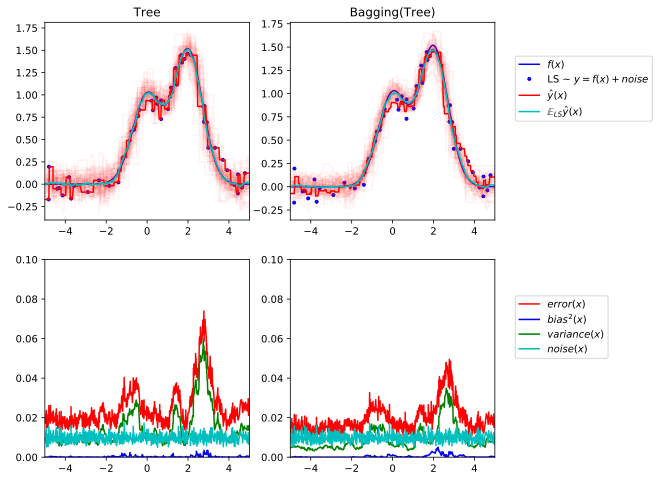

In [38]:
print(__doc__)

# Author: Gilles Louppe <g.louppe@gmail.com>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Settings
n_repeat = 50       # Number of iterations for computing expectations
n_train = 50        # Size of the training set
n_test = 1000       # Size of the test set
noise = 0.1         # Standard deviation of the noise
np.random.seed(0)

# Change this for exploring the bias-variance decomposition of other
# estimators. This should work well for estimators with high variance (e.g.,
# decision trees or KNN), but poorly for estimators with low variance (e.g.,
# linear models).
estimators = [("Tree", DecisionTreeRegressor()),
              ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor()))]

n_estimators = len(estimators)


# Generate data
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)


def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y


X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

plt.figure(figsize=(10, 8))

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label="$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label="$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == n_estimators - 1:

        plt.legend(loc=(1.1, .5))

plt.subplots_adjust(right=.75)
plt.show()

###### Decision Tree VS Decision Trees with Bagging 2.0

In [39]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), 
    n_estimators=500,
    max_samples=100, 
    bootstrap=True, 
    n_jobs=-1, 
    random_state=42
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [40]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [41]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [42]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

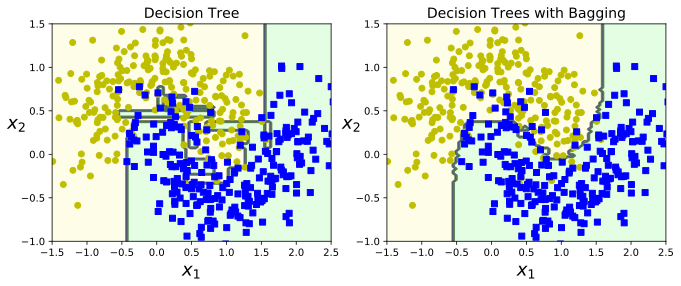

In [43]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.show()

## Random subspace method

Идея: брать случайные признаки.<br>
Данный метод эффективен в задачах с большим числом признаков и небольшим числом объектов, а также при наличии неинформативных признаков. В этих случаях классификаторы, построенные по части признакового описания, могут обладать лучшей обобщающей способностью по сравнению с классификаторами, построенными с использованием всех признаков.

| idx | a | b | c |
|---|---|---|---|
|1   | 0.1  | 0.01  | 10  |
|2  | 0.2  | 0.02  |  20 |
|3   |  0.3 | 0.03  | 30  |
|4   |  0.4 |  0.04 | 40  |

| idx | a |c |
|---|---|---|
|1   | 0.1  |10  |
|2  | 0.2  | 20 |
|3   |  0.3 | 30  |
|4   |  0.4 | 40  |

| idx | a | b | 
|---|---|---|
|1   | 0.1  | 0.01  |
|2  | 0.2  | 0.02  |
|3   |  0.3 | 0.03  |
|4   |  0.4 |  0.04 |

## Random Patches method

Брать случайные признаки и случайные примеры

| idx | a | b | c |
|---|---|---|---|
|1   | 0.1  | 0.01  | 10  |
|2  | 0.2  | 0.02  |  20 |
|3   |  0.3 | 0.03  | 30  |
|4   |  0.4 |  0.04 | 40  |

| idx | a |c |
|---|---|---|
|2  | 0.2  | 20 |
|4   |  0.4 | 40  |

| idx | a | b | 
|---|---|---|
|2  | 0.2  | 0.02  |
|3   |  0.3 | 0.03  |

## Random forest

<img src='random_forest.jpg' width=50%>

1. $X_1, X_2, ..., X_N$ - объекты выборки,
   $f_1, f_2, ..., f_M$ - признаки
2. $n_{models}$ - количество моделей в ансамбле
3. Для каждой модели выбираем количество признаков $m \le M$
4. Для каждой из моделей бутстрэпим выборку и обучаем модель на ней
5. Результатом работы случайного леса будет усредненное значение результатов отдельных моделей.

Параметры RandomForestRegressor-a:
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

### Decision Tree with Bagging VS Random Forest

In [44]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

In [45]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [46]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [47]:
np.sum(y_pred == y_pred_rf) * 1. / len(y_pred)  # almost identical predictions

0.97599999999999998

### Ирисы

In [48]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.112492250999
sepal width (cm) 0.0231192882825
petal length (cm) 0.441030464364
petal width (cm) 0.423357996355


In [49]:
rnd_clf.feature_importances_

array([ 0.11249225,  0.02311929,  0.44103046,  0.423358  ])

In [50]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

# Out-of-bag error

Каждое дерево строится с использованием разных образцов бутстрэпа из исходных данных. Примерно 37% примеров остаются вне выборки бутстрэпа и не используются при построении k-го дерева.


Покажем, что в каждую подвыборку с возвращением попадает примерно 63% исходных объектов.

Пусть в выборке $\ell$ объектов. На каждом шаге все объекты попадают в подвыборку с возвращением равновероятно, т.е отдельный объект - с вероятностью  $\Large \frac{1}{\ell}.$ Вероятность того, что объект НЕ попадет в подвыборку (т.е его не взяли $\ell$ раз): $\Large (1 - \frac{1}{\ell})^\ell$. При $\ell \rightarrow +\infty$ получаем один из "замечательных" пределов $\Large \frac{1}{e}$. Тогда вероятность попадания конкретного объекта в подвыборку $\Large \approx  1 - \frac{1}{e} \approx 63\%$.

Каждый базовый алгоритм обучается на ~63% исходных объектов. Значит, на оставшихся ~37% его можно сразу проверять. Out-of-Bag оценка - это усредненная оценка базовых алгоритмов на тех ~37%, на которых они не обучались.

<img src='pics/oobe.png'>

Слева то на чем тренируемся, справа то, на чем валидируемся.

# Важность признаков

- Чем выше признак в дереве, тем выше его важность.
Чем больше уменьшается точность предсказаний из-за исключения (или перестановки) одной переменной, тем важнее эта переменная 

- Для того, чтобы оценить важность j-го параметра после тренировки, значения j-го параметра перемешиваются для всех записей тренировочного набора (либо параметр совсем исключается из тренировочных данных) и out-of-bag-ошибка считается снова. Важность параметра оценивается путём усреднения по всем деревьям разности показателей out-of-bag-ошибок до и после перемешивания значений. При этом значения таких ошибок нормализуются на стандартное отклонение.

In [51]:
import pandas as pd
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [52]:
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [53]:
rnd_clf.feature_importances_

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   3.09335168e-06,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   5.01002598e-06,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,

In [54]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,interpolation="nearest")
    plt.axis("off")

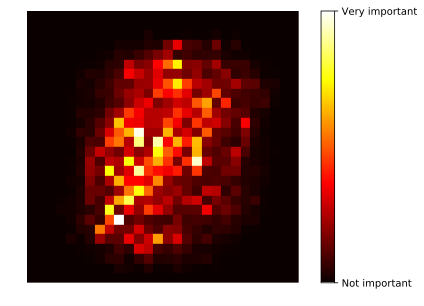

In [55]:
plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.show()

# Extremely Randomized Trees

Случайным образом выбирать порог для разбиения в узлах деревьев (случайный набор порогов -> выбираем лучший порог)

In [56]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))

ex_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
ex_clf.fit(X_train, y_train)

y_pred_ex = ex_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_ex))

0.912
0.912


## Плюсы и минусы случайного леса:

\+ не требует тщательной настройки параметров, идеален для запуска "из коробки" <br>
\+ хорошо работает на больших выборках (много признаков/много данных) <br>
\+ не сильно чувствителен к изменению параметров <br>
\+ не чувствителен к выбросам в данных из-за случайного сэмлирования <br>
\+ не чувствителен к масштабированию признаков <br>
\+ есть оценка важности признаков <br>
\+ параллелизуется <br>

\- плохо работает на разреженных выборках(тексты) <br>
\- занимает много памяти <br>
\- плохо интерпретируются <br>
\- градиентный бустинг работает в большинстве случаев так же, но быстрее и потребляет меньше памяти (лесу требуются глубокие деревья, а бустингу мелкие) <br>

# Boosting

* Обучить модель
* Посчитать ошибки
* Учесть ошибки и обучить новую модель
* Повторять некоторое количество раз

Нельзя обучать параллельно

# AdaBoost
Будем влиять на вес тренировочных примеров, участвующих в обучении.  
Из этих весов сможем рассчитывать вес модели

Веса $w_i$ каждого обучающего примера $X_i$
$$X = \begin{bmatrix} 
a_1 & b_1 & c_1 & ... \\ 
a_2 & b_2 & c_2 & ... \\ 
a_3 & b_3 & c_3 & ... \\
... & ... & ... & ...
\end{bmatrix}, \space 
w = \begin{bmatrix} 
w_1 \\ 
w_2 \\ 
w_3 \\
... 
\end{bmatrix}$$

initially

$$w_i = \frac{1}{m}$$


$m$ - количество примеров в обучающей выборке (количество строк в $X$)

Обучаем модель и считаем ее error rate:


$$r = \frac{\sum\limits_{\hat{y} \neq y}{w}}{\sum w}$$

Чем больше ошибок, тем больше $r$

Считаем вес модели:

$$ \alpha = \eta log \frac{1-r}{r} $$

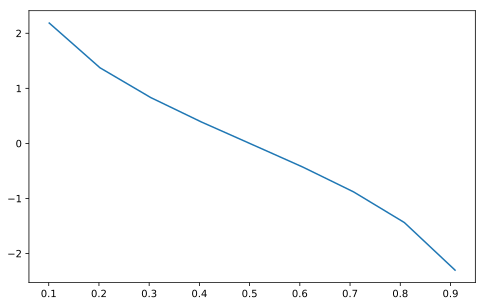

In [59]:
def f(x):
    return np.log((1 - x) / x)

x = np.linspace(0, 10, 100)
y = f(x)
plt.plot(x, y);

Обновим веса:

$w$ не меняется, если предсказание верное   
$w \leftarrow w \cdot e^{\alpha} $, если предсказание ошибочное

Все веса нормализуются, делятся на $\sum w$

In [68]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

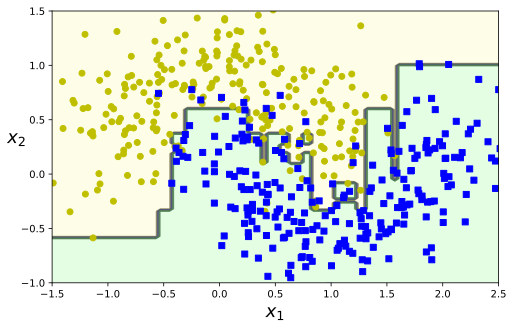

In [69]:
plot_decision_boundary(ada_clf, X, y)

# Stacking, blending

In [60]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [61]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

X_in, X_out, y_in, y_out = train_test_split(X_train, y_train, random_state=42) # hold-out - blending. 

In [62]:
svm_clf.fit(X_in, y_in)
rnd_clf.fit(X_in, y_in)

svm_y = svm_clf.predict(X_out)
rnd_y = rnd_clf.predict(X_out)

In [63]:
log_clf.fit(np.c_[svm_y, rnd_y], y_out)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [64]:
y_stack = log_clf.predict(np.c_[svm_clf.predict(X_test), rnd_clf.predict(X_test)])

In [65]:
accuracy_score(y_test, y_stack)

0.86399999999999999

In [66]:
accuracy_score(y_test, rnd_clf.predict(X_test))

0.90400000000000003

### Задача
Есть базовые алгоритмы SVM, KNN, DecisionTree и 2 вида композиций: беггинг, бустинг. Для каких алгоритмов какие способы композиций будут работать лучше?

## Дополнительные материалы:
[Bias Variance tradeoff](https://en.wikipedia.org/wiki/Bias–variance_tradeoff)

http://scott.fortmann-roe.com/docs/BiasVariance.html

[Заметка А.Дьяконова о случайных лесах (как влияют параметры)](https://dyakonov.org/2016/11/14/случайный-лес-random-forest/)

https://www.kaggle.com/general/18793  

[Важная презентация про случайный лес](http://docs.salford-systems.com/AdeleCutler.pdf)

[Статья А.Дьяконова про блендинг и стекинг](https://dyakonov.org/2017/03/10/cтекинг-stacking-и-блендинг-blending/)